### Bayesian Optimisation for finding interaction coefficients for randomly generated 2D lattice

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import Matern

In [7]:
e_x = 10 * (np.random.rand(2) * 2 - 1)
e_y = 10 * (np.random.rand(2) *2 - 1)

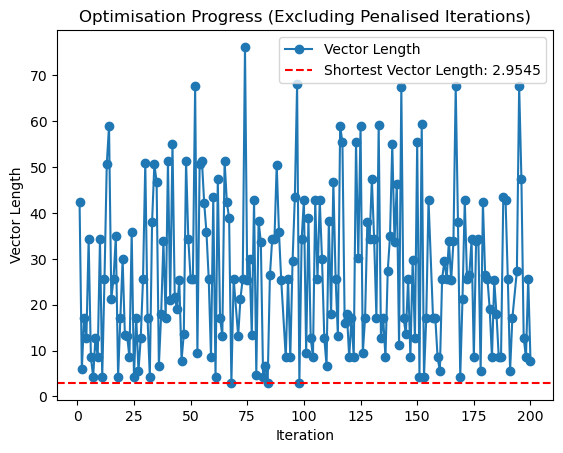

Optimised eta coefficients: [0.5785321273232018, 0.09810175199917781, 0.5918116984001747, -0.15803005789342106, -0.39993204280912054, -0.4623091462506562, 0.0698586012129283]
Vector length for optimised eta coefficients: 2.954500734781878


In [14]:
def pauli_z():
    return np.array([[1, 0], [0, -1]])

def identity():
    return np.eye(2)

def tensor_product(operators):
    result = operators[0]
    for op in operators[1:]:
        result = np.kron(result, op)
    return result

def construct_hamiltonian(num_qubits, coefficients, mu):
    H = np.zeros((2**num_qubits, 2**num_qubits))
    
    for i, coeff in enumerate(coefficients):
        ops = [identity()] * num_qubits
        ops[i] = pauli_z()
        ops[(i + 1) % num_qubits] = pauli_z()
        H += coeff * tensor_product(ops)
    
    for i in range(num_qubits):
        ops = [identity()] * num_qubits
        ops[i] = pauli_z()
        H += mu * tensor_product(ops)
    
    return H

def compute_eigenvalues_and_eigenvectors(H):
    eigenvalues, eigenvectors = np.linalg.eig(H)
    return eigenvalues, eigenvectors

def order_eigenvectors_by_energy(eigenvalues, eigenvectors):
    sorted_indices = np.argsort(eigenvalues)
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    return sorted_eigenvalues, sorted_eigenvectors

def decode_eigenvector_amplitude_based(eigenvector, num_bits_per_coordinate):
    total_probability = 0
    weighted_x_sum = 0
    weighted_y_sum = 0
    
    for index, amplitude in enumerate(eigenvector):
        probability = np.abs(amplitude)**2
        total_probability += probability
        
        binary_str = format(index, f'0{2 * num_bits_per_coordinate}b')
        x_bin = binary_str[:num_bits_per_coordinate]
        y_bin = binary_str[num_bits_per_coordinate:]
        
        def signed_magnitude_decode(bin_str):
            sign = int(bin_str[0])
            magnitude = int(bin_str[1:], 2)
            return magnitude if sign == 0 else -magnitude
        
        x = signed_magnitude_decode(x_bin)
        y = signed_magnitude_decode(y_bin)
        
        weighted_x_sum += probability * x
        weighted_y_sum += probability * y
    
    if total_probability == 0:
        return (0, 0)  # prevent division by zero
    
    average_x = weighted_x_sum / total_probability
    average_y = weighted_y_sum / total_probability
    
    return (average_x, average_y)

def calculate_vector_length(decoded_coordinates, e_x, e_y):
    a, b = decoded_coordinates
    v = a * e_x + b * e_y
    return np.linalg.norm(v)

num_qubits = 8
mu = 0.0001

# parameter space 
space = [Real(-1.0, 1.0, name=f'eta_{i}') for i in range(num_qubits - 1)]

# Matern kernel 
kernel = 1.0 * Matern(length_scale=1.0, nu=0.5)

# objective function 
@use_named_args(space)
def objective(**params):
    eta_coefficients = np.array([params[f'eta_{i}'] for i in range(num_qubits - 1)])
    H = construct_hamiltonian(num_qubits, eta_coefficients, mu)
    eigenvalues, eigenvectors = compute_eigenvalues_and_eigenvectors(H)
    sorted_eigenvalues, sorted_eigenvectors = order_eigenvectors_by_energy(eigenvalues, eigenvectors)
    
    first_excited_eigenvector = sorted_eigenvectors[:, 1]
    decoded_coordinates = decode_eigenvector_amplitude_based(first_excited_eigenvector, num_bits_per_coordinate=4)
    vector_length = calculate_vector_length(decoded_coordinates, e_x, e_y)
    
    if np.isclose(vector_length, 0):
        return 1e6  # a large penalty value
    
    return vector_length

result = gp_minimize(
    objective, 
    space, 
    base_estimator=GaussianProcessRegressor(kernel=kernel), 
    acq_func="EI",  
    n_calls=200,    
    random_state=0
)

penalty_threshold = 1e5  # set a threshold below the penalty value to filter them out

# Create arrays for the filtered values
filtered_iterations = []
filtered_func_vals = []

for i, val in enumerate(result.func_vals):
    if val < penalty_threshold:  # only keep values that are below the penalty threshold
        filtered_iterations.append(i + 1)  
        filtered_func_vals.append(val)  

min_vector_length = min(filtered_func_vals)

plt.plot(filtered_iterations, filtered_func_vals, marker='o', label='Vector Length')

# horizontal dotted line for the shortest vector length
plt.axhline(y=min_vector_length, color='r', linestyle='--', label=f'Shortest Vector Length: {min_vector_length:.4f}')

plt.xlabel('Iteration')
plt.ylabel('Vector Length')
plt.title('Optimisation Progress (Excluding Penalised Iterations)')
plt.legend()

plt.show()

best_eta_coefficients = result.x
print(f"Optimised eta coefficients: {best_eta_coefficients}")

H = construct_hamiltonian(num_qubits, best_eta_coefficients, mu)
eigenvalues, eigenvectors = compute_eigenvalues_and_eigenvectors(H)
sorted_eigenvalues, sorted_eigenvectors = order_eigenvectors_by_energy(eigenvalues, eigenvectors)
first_excited_eigenvector = sorted_eigenvectors[:, 1]
decoded_coordinates = decode_eigenvector_amplitude_based(first_excited_eigenvector, num_bits_per_coordinate=4)
vector_length = calculate_vector_length(decoded_coordinates, e_x, e_y)
print(f"Vector length for optimised eta coefficients: {vector_length}")